In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Loading dataset
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
df = pd.read_csv(url, parse_dates=["date"])

# Raw data sample
print(df.head())
print("\nDataset shape:", df.shape)
print("Columns:", df.columns.tolist())

        date       state  fips  cases  deaths
0 2020-01-21  Washington    53      1       0
1 2020-01-22  Washington    53      1       0
2 2020-01-23  Washington    53      1       0
3 2020-01-24    Illinois    17      1       0
4 2020-01-24  Washington    53      1       0

Dataset shape: (61942, 5)
Columns: ['date', 'state', 'fips', 'cases', 'deaths']


In [47]:
# Sorting data and computing daily new cases/deaths
df = df.sort_values(["state", "date"])
df["new_cases"] = df.groupby("state")["cases"].diff().fillna(0)
df["new_deaths"] = df.groupby("state")["deaths"].diff().fillna(0)

# Clip negative values
df["new_cases_clean"] = df["new_cases"].clip(lower=0)

# Compute 7-day rolling average per state
df["new_cases_7day"] = (
    df.groupby("state")["new_cases_clean"]
      .rolling(7)
      .mean()
      .reset_index(0, drop=True)
)

# Ensure no negative values first
df["new_deaths_clean"] = df["new_deaths"].clip(lower=0)

# Compute 7-day rolling average per state
df["new_deaths_7day"] = (
    df.groupby("state")["new_deaths_clean"]
      .rolling(7)
      .mean()
      .reset_index(0, drop=True)
)

# Data with daily counts
print(df.head())

        date    state  fips  cases  deaths  new_cases  new_deaths  \
0 2020-03-13  Alabama     1      6       0        0.0         0.0   
1 2020-03-14  Alabama     1     12       0        6.0         0.0   
2 2020-03-15  Alabama     1     23       0       11.0         0.0   
3 2020-03-16  Alabama     1     29       0        6.0         0.0   
4 2020-03-17  Alabama     1     39       0       10.0         0.0   

   new_cases_clean  new_cases_7day  new_deaths_clean  new_deaths_7day  
0              0.0             NaN               0.0              NaN  
1              6.0             NaN               0.0              NaN  
2             11.0             NaN               0.0              NaN  
3              6.0             NaN               0.0              NaN  
4             10.0             NaN               0.0              NaN  


In [9]:
# Summary statistics for cumulative counts
print("\nCases Summary Statistics:")
print(df["cases"].describe())

print("\nDeaths Summary Statistics:")
print(df["deaths"].describe())


Cases Summary Statistics:
count    6.194200e+04
mean     8.898301e+05
std      1.470231e+06
min      1.000000e+00
25%      7.078350e+04
50%      3.514960e+05
75%      1.043231e+06
max      1.216916e+07
Name: cases, dtype: float64

Deaths Summary Statistics:
count     61942.000000
mean      11779.067499
std       17345.774849
min           0.000000
25%        1171.000000
50%        5035.000000
75%       14912.000000
max      104277.000000
Name: deaths, dtype: float64


In [13]:
# Summary statistics for daily new cases or new deaths
print("\nNew Cases: 7 day rolling average")
print(df["new_cases_7day"].describe())
print("\nNew Deaths: 7 day rolling average")
print(df["new_deaths_7day"].describe())


New Cases: 7 day rolling average
count     61606.000000
mean       1687.689803
std        4177.566371
min           0.000000
25%         172.428571
50%         606.071429
75%        1637.714286
max      119536.142857
Name: new_cases_7day, dtype: float64

New Deaths: 7 day rolling average
count    61606.000000
mean        18.545471
std         39.751659
min          0.000000
25%          1.714286
50%          6.571429
75%         18.857143
max        978.428571
Name: new_deaths_7day, dtype: float64


In [51]:
# National-level aggregates
national = df.groupby("date")[["new_cases_7day", "new_deaths_7day"]].sum()
print(national.head())
print("\nNational New Cases: 7 day rolling")
print(national["new_cases_7day"].describe())
print("\nNational New Deaths: 7 day rolling")
print(national["new_deaths_7day"].describe())

            new_cases_7day  new_deaths_7day
date                                       
2020-01-21             0.0              0.0
2020-01-22             0.0              0.0
2020-01-23             0.0              0.0
2020-01-24             0.0              0.0
2020-01-25             0.0              0.0

National New Cases: 7 day rolling
count      1158.000000
mean      89785.680484
std      112696.815005
min           0.000000
25%       35562.714286
50%       60474.142857
75%      107415.785714
max      806927.857143
Name: new_cases_7day, dtype: float64

National New Deaths: 7 day rolling
count    1158.000000
mean      986.625463
std       778.973774
min         0.000000
25%       394.892857
50%       722.571429
75%      1412.750000
max      3362.142857
Name: new_deaths_7day, dtype: float64


In [52]:
state_summary = (
    df.sort_values(["state", "date"])
      .groupby("state")
      .agg({"cases": "last", "deaths": "last"})
      .sort_values("cases", ascending=False)
)

print(state_summary.head(10))

                   cases  deaths
state                           
California      12169158  104277
Texas            8447168   94518
Florida          7542869   87141
New York         6805271   80109
Illinois         4107931   41618
Pennsylvania     3539135   50701
North Carolina   3481732   29746
Ohio             3415254   42061
Michigan         3068195   42311
New Jersey       3057442   36097


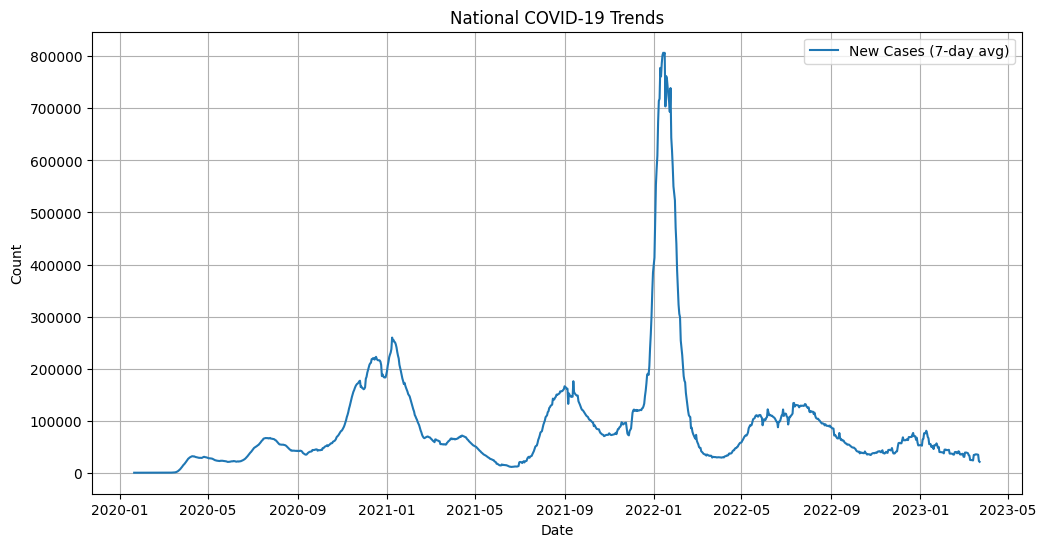

In [72]:
plt.figure(figsize = (12,6))
plt.plot(national.index, national["new_cases_7day"], label="New Cases (7-day avg)")
plt.title("National COVID-19 Trends")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.savefig("national_cases_plt.pdf", bbox_inches="tight")
plt.show()


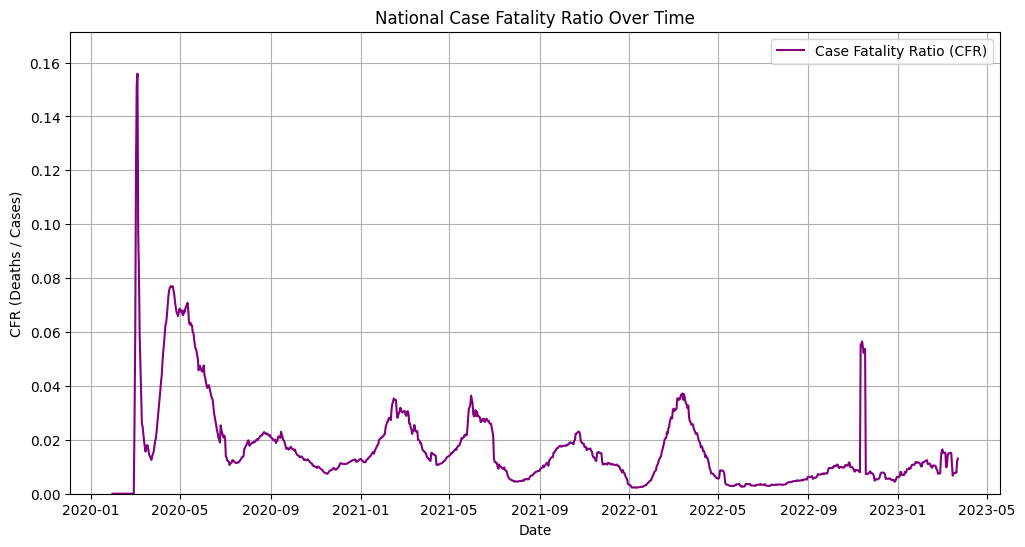

In [71]:
# Compute CFR (avoid division by zero)
national["CFR"] = (
    national["new_deaths_7day"] / national["new_cases_7day"].replace(0, np.nan)
)


# Plot CFR over time
plt.figure(figsize=(12,6))
plt.plot(national.index, national["CFR"], color="purple", label="Case Fatality Ratio (CFR)")
plt.title("National Case Fatality Ratio Over Time")
plt.xlabel("Date")
plt.ylabel("CFR (Deaths / Cases)")
plt.ylim(0, national["CFR"].max()*1.1)
plt.grid(True)
plt.legend()
plt.savefig("cfr_plot.pdf", bbox_inches="tight")
plt.show()


In [73]:
# URL for the Census Bureau state population estimates file (2020–2023)
pop_url = "https://www2.census.gov/programs-surveys/popest/datasets/2020-2023/state/totals/NST-EST2023-ALLDATA.csv"

# Load the CSV
pop_df = pd.read_csv(pop_url)

# Filter for state total rows (SUMLEV == 40 indicates state geographies)
exclude = ["Puerto Rico", "District of Columbia"]

pop_states = (
    pop_df[pop_df["SUMLEV"] == 40]
    .query('NAME not in @exclude')
    .copy()
)

# Extract only the 2020 population estimates
pop_states_2020 = pop_states[["NAME", "POPESTIMATE2020"]].copy()
pop_states_2020.columns = ["state", "pop_2020"]

# Reset index
pop_states_2020 = pop_states_2020.reset_index(drop=True)

# View the processed 2020 state populations
print("\nState population estimates for 2020:")
print(pop_states_2020)

# Summary statistics
print("\nSummary statistics for 2020 populations:")
print(pop_states_2020["pop_2020"].describe())



State population estimates for 2020:
             state  pop_2020
0          Alabama   5031864
1           Alaska    732964
2          Arizona   7186683
3         Arkansas   3014348
4       California  39503200
5         Colorado   5785219
6      Connecticut   3577586
7         Delaware    991862
8          Florida  21591299
9          Georgia  10732390
10          Hawaii   1451181
11           Idaho   1849339
12        Illinois  12790357
13         Indiana   6789098
14            Iowa   3190904
15          Kansas   2938124
16        Kentucky   4508155
17       Louisiana   4652022
18           Maine   1364517
19        Maryland   6173689
20   Massachusetts   6997713
21        Michigan  10070627
22       Minnesota   5710578
23     Mississippi   2958409
24        Missouri   6154426
25         Montana   1087211
26        Nebraska   1963273
27          Nevada   3115840
28   New Hampshire   1378702
29      New Jersey   9272392
30      New Mexico   2118488
31        New York  20104710
32  N

In [74]:
# Merge state totals with population
state_stats = (
    state_summary
    .merge(pop_states_2020, on="state")
)

# Compute per-capita values
state_stats["cases_per_100k"] = (state_stats["cases"] / state_stats["pop_2020"]) * 100000
state_stats["deaths_per_100k"] = (state_stats["deaths"] / state_stats["pop_2020"]) * 100000

# Compute CFR (%) at state level
state_stats["cfr_percent"] = (state_stats["deaths"] / state_stats["cases"]) * 100

print(state_stats.sort_values("cases", ascending=False).head(10))

            state     cases  deaths  pop_2020  cases_per_100k  \
0      California  12169158  104277  39503200    30805.499301   
1           Texas   8447168   94518  29234361    28894.655847   
2         Florida   7542869   87141  21591299    34934.762378   
3        New York   6805271   80109  20104710    33849.137839   
4        Illinois   4107931   41618  12790357    32117.406887   
5    Pennsylvania   3539135   50701  12995477    27233.590579   
6  North Carolina   3481732   29746  10453812    33305.860102   
7            Ohio   3415254   42061  11798292    28947.020467   
8        Michigan   3068195   42311  10070627    30466.772327   
9      New Jersey   3057442   36097   9272392    32973.605948   

   deaths_per_100k  cfr_percent  
0       263.971020     0.856896  
1       323.311325     1.118931  
2       403.593133     1.155277  
3       398.458869     1.177161  
4       325.385757     1.013113  
5       390.143432     1.432582  
6       284.546919     0.854345  
7       356.

In [68]:
import requests
import json
from shapely.geometry import shape

# GeoJSON file with U.S. state boundaries
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
geojson = requests.get(url).json()

# Build geometry dictionary
polygons = {}
for feature in geojson["features"]:
    state = feature["properties"]["name"]

    # Skip territories
    if state in ["Puerto Rico"]:
        continue

    polygons[state] = shape(feature["geometry"])

# Compute adjacency
adjacency = {state: [] for state in polygons}
states = list(polygons.keys())

for i, s1 in enumerate(states):
    for j in range(i + 1, len(states)):
        s2 = states[j]

        # If polygons touch along a border, they are adjacent
        try:
            if polygons[s1].touches(polygons[s2]):
                adjacency[s1].append(s2)
                adjacency[s2].append(s1)
        except Exception:
            pass  # Rare geometry error fallback


print(adjacency)


{'Alabama': ['Florida', 'Georgia', 'Mississippi', 'Tennessee'], 'Alaska': [], 'Arizona': ['California', 'Colorado', 'Nevada', 'New Mexico', 'Utah'], 'Arkansas': ['Louisiana', 'Mississippi', 'Missouri', 'Oklahoma', 'Tennessee', 'Texas'], 'California': ['Arizona', 'Nevada', 'Oregon'], 'Colorado': ['Arizona', 'Kansas', 'Nebraska', 'New Mexico', 'Oklahoma', 'Utah', 'Wyoming'], 'Connecticut': ['Massachusetts', 'New York', 'Rhode Island'], 'Delaware': ['Maryland', 'New Jersey', 'Pennsylvania'], 'District of Columbia': ['Maryland', 'Virginia'], 'Florida': ['Alabama', 'Georgia'], 'Georgia': ['Alabama', 'Florida', 'North Carolina', 'South Carolina', 'Tennessee'], 'Hawaii': [], 'Idaho': ['Montana', 'Nevada', 'Oregon', 'Utah', 'Washington', 'Wyoming'], 'Illinois': ['Indiana', 'Iowa', 'Kentucky', 'Missouri', 'Wisconsin'], 'Indiana': ['Illinois', 'Kentucky', 'Michigan', 'Ohio'], 'Iowa': ['Illinois', 'Minnesota', 'Missouri', 'Nebraska', 'South Dakota', 'Wisconsin'], 'Kansas': ['Colorado', 'Missouri'